In [66]:
import numpy as np 
import pandas as pd
import seaborn as sns
import time
import datetime

In [67]:
df = pd.read_csv('sleepdata.csv',delimiter=";")
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91%,9:08,NaN,NaN,NaN,56
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81%,7:11,NaN,NaN,NaN,64
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71%,8:56,NaN,NaN,NaN,3316
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80%,9:13,NaN,NaN,NaN,6555


### 1. Management of the data <a class="anchor" id="section_5_2"></a>

First, we clean the data, and use some predictors to replace the missing values.

We directly notice that our data is full of missing values, for the proportion of lines that we see above. So we will try to count how many of them they are, in order to take measure for them.

In [68]:
df.isnull().sum()

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

We see that our data is incomplete, and that they are a lot of 0 values for activities steps, which seems impossible. Because theses values seem to totally wrong, we have to replace them by a "NaN" value to keep consistency.

In [69]:
cols = ["Start","End","Sleep quality","Time in bed","Wake up","Sleep Notes","Heart rate","Activity (steps)"]
df[cols] = df[cols].replace({'0':np.nan, 0:np.nan})

# Check the number of missing values in each column
df.isnull().sum()

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)    418
dtype: int64

Now, it seems like there are way more missing values than we thought. One of the most common strategy in this situation is simply dropping all the records with NaNs. But if we do that we our current data, not a single row will be remaining, so the thing we can do is taking this information for later. And, because theses features account for more than 5% the size of our dataset, so we should still keep them.

We can see the heatmap taking showing the repartition of missing values and their time of apparition.

Number of rows after dropping missing records:  0


<AxesSubplot:>

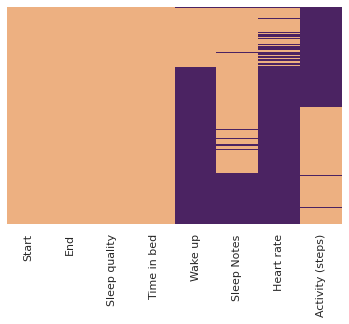

In [70]:
# drop records which contain missing values
data_dropped = df.dropna()
print("Number of rows after dropping missing records: ", len(data_dropped))
#check the null part in the whole data set, red part is missing data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='flare')

We will make some predictions about the heart rate and the activity (steps) and the heart rate with our existing data. We will have to change types of wake up values to 1 (happy = ":)"), 0.5 (neutral =":|) and 0 (unhappy =":("), so that they're easier to handle with mean and standard deviation. Moreover, because start and end time of sleep can be various, we should replace our current "Time in bed" which is a string by an actual number which might be more consistent and can be used for the predictors. So, it will give an overall best precision.

In [71]:
df['Wake up'] = df['Wake up'].replace({':)':1, ':|':0.5,':(':0})
df['Sleep quality'] = pd.Series([ val.replace("%","") for val in df['Sleep quality']]).astype(int)

Then we use the "Start" and "End" columns, to compute the total sleeping time of each row of our dataframe.

In [72]:
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

df['Time in bed'] = pd.Series(df['End'] - df['Start']).astype('timedelta64[s]')/3600


df['Start (hours)'] = pd.Series([val.hour *3600 + val.minute *60 + val.second 
                                 for val in df['Start']])/3600
df['End (hours)'] = pd.Series([val.hour *3600 + val.minute *60 + val.second 
                               for val in df['End']])/3600

We will try to find correlations between the features now already, and make some assumptions. And then redo the same thing but after applying some predictors to our data to complete the missing data. For the correlation matrix to work, we need to convert sleep quality to float and to not use "Start" and "End" feature.

Text(0.5, 1.0, 'Correlation')

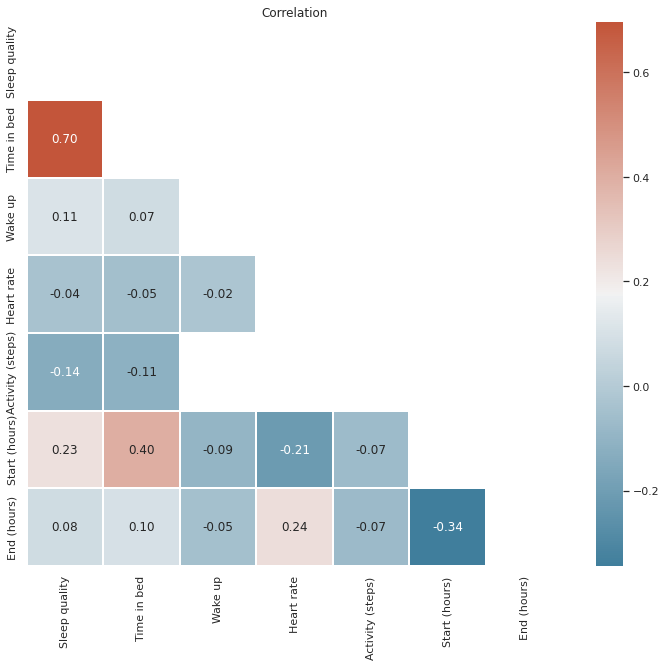

In [73]:
import matplotlib.pyplot as plt

# visualisation of this correlation
fig = plt.figure(figsize = (12,10))
sns.set_theme(style="white")

corr = df.corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generating a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

r = sns.heatmap(corr,cmap=cmap,fmt=".2f", linewidths = 0.05,annot = True,mask = mask)
# set title
r.set_title('Correlation')

If we try to display our results already about correlation with the sleep quality, here are the results :  

In [74]:
df.corr()['Sleep quality'].sort_values()

Activity (steps)   -0.136605
Heart rate         -0.037846
End (hours)         0.076523
Wake up             0.110043
Start (hours)       0.234936
Time in bed         0.695206
Sleep quality       1.000000
Name: Sleep quality, dtype: float64

We can notice that "Time in bed" seems to the most correlated feature with "Sleep quality".

Moreover, we can observe that "Activity (steps)" and "Sleep quality" are not correlated at all, despite the general belief that some exercice help for a better sleep quality.

Now, we can start handling the data with mean and standard deviation, using predictions on our data. "Sleep notes" is a data I don't know how to handle now, I might try to do a dictionnary with certain words that can help predicting the sleep quality with terms like "stress" or "drank coffee or tea".

In [75]:
from sklearn.impute import SimpleImputer

# Define the imputer. We use 'mean' as the imputing strategy.
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# We will continue our work on a copy of the original data and delete 'Sleep Notes'
data_preprocessed = df.copy()
# predict column wake up
data_preprocessed['Wake up'] = imp_mean.fit_transform(data_preprocessed[['Wake up']])
# predict column activity steps
data_preprocessed['Activity (steps)'] = imp_mean.fit_transform(data_preprocessed[['Activity (steps)']])
# predict column heart rate
data_preprocessed['Heart rate'] = imp_mean.fit_transform(data_preprocessed[['Heart rate']])
data_preprocessed.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start (hours),End (hours)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,8.540000,1.000000,NaN,59.000000,5250.848614,22.963611,7.503611
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,0.267778,0.500000,Stressful day,72.000000,5250.848614,21.297222,21.565000
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,8.511667,0.500000,NaN,57.000000,5250.848614,22.713611,7.225278
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,7.533333,0.936992,NaN,60.604938,5250.848614,22.516944,6.050278
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,6.740278,1.000000,Drank coffee:Drank tea,68.000000,5250.848614,22.202778,4.943056


### 2. Analysis of our data <a class="anchor" id="section_5_2"></a>

Now, we will try to plot and play with our data to extract some observations on the subject.

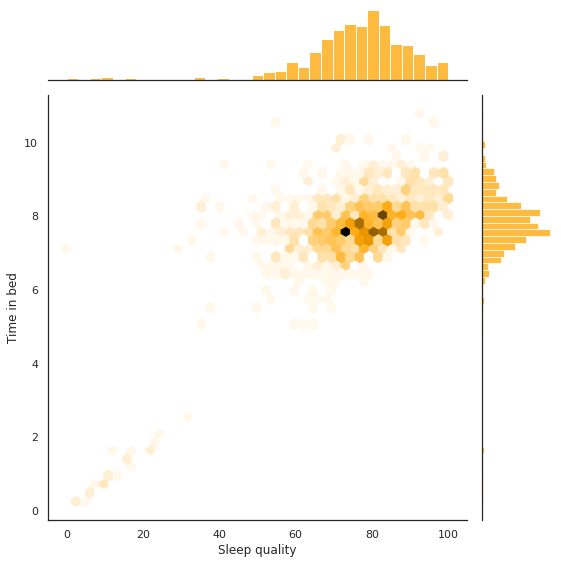

In [76]:
# Joint plot of features "Sleep quality" and "Time in bed" with unit hour.
ax = sns.jointplot(data=df,
              x='Sleep quality',
              y='Time in bed',
              kind='hex',
              color ='orange',
              height=8)
plt.show()

In [77]:
##### The average of "Time in bed" in seconds and hours

print ('Average sleep quality :', df['Sleep quality'].mean(),'%')
print ('Average time of bed time of this person :', df['Time in bed'].mean(), 'hour')

Average sleep quality : 74.89515219842164 %
Average time of bed time of this person : 7.651459664286615 hour


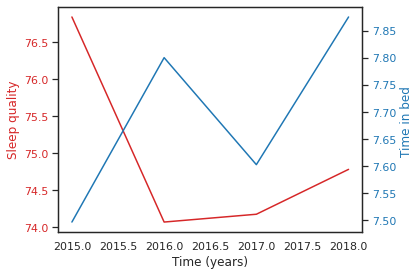

In [78]:
#Average sleep quality and time of bed time during the years, 2014 is combined with 2015 because of lack of data
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


df2015 = pd.DataFrame()
df2016 = pd.DataFrame()
df2017 = pd.DataFrame()
df2018 = pd.DataFrame()

df2015 = pd.Series([x.year == 2014 or x.year == 2015 for x in df['Start']])
df2016 = pd.Series([x.year == 2016 for x in df['Start']])
df2017 = pd.Series([x.year == 2017 for x in df['Start']])
df2018 = pd.Series([x.year == 2018 for x in df['Start']])

df2015 = df[df2015 == True] 
df2016 = df[df2016 == True] 
df2017 = df[df2017 == True] 
df2018 = df[df2018 == True] 

years = np.array([2015,2016,2017,2018])
sleep = np.array([df2015['Sleep quality'].mean(),df2016['Sleep quality'].mean(),
                  df2017['Sleep quality'].mean(),df2018['Sleep quality'].mean()])
time_in_bed = np.array([df2015['Time in bed'].mean(),df2016['Time in bed'].mean(),
                  df2017['Time in bed'].mean(),df2018['Time in bed'].mean()])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Sleep quality', color=color)
ax1.plot(years, sleep, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Time in bed ', color=color)  # we already handled the x-label with ax1
ax2.plot(years, time_in_bed, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



The changes that we can observe throughout the years are not that relevant, so we cannot make any assumptions.

Now, we will try to see the proportion of sleep times the person is having during his study. Categorizing in 3 bins : Oversleep if the sleep duration is > 8 hours, Adequate if the sleep duration lies between 6 hours (excluded) and 8 hours (included) and Inadequate if the sleep duration is  ≤  6 hours.

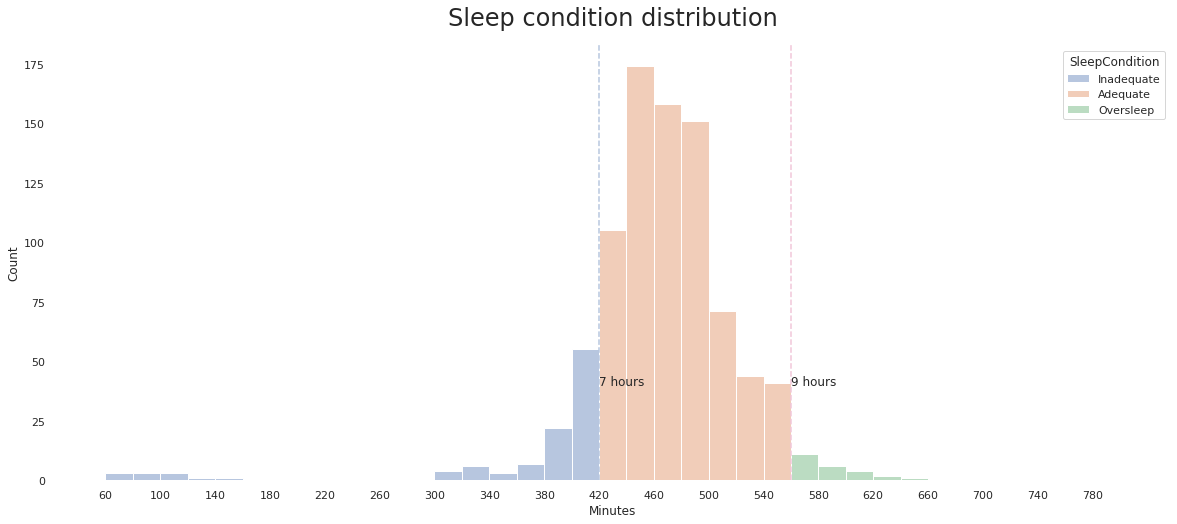

In [79]:
# Separating our data into the 3 bins of bed time: 
df6 = df.copy()
df6['Time in bed'] = df6['Time in bed']*60

bed_times = pd.Series(df6['Time in bed'])

a = pd.cut(bed_times, bins = [0,420,560,bed_times.max()], right=True,labels=['Inadequate', 'Adequate', 'Oversleep'], 
           retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)

fig, ax = plt.subplots(figsize=(20,8))

df6['SleepCondition'] = a

#Plotting our results and showing the proportions of our differents categories
sns.histplot(ax=ax, data=df6, x="Time in bed", hue="SleepCondition", multiple="stack", alpha=0.4, bins=40, binwidth=20, binrange=(60.00001,800))
ax.axvline(x=420, color='#b7c6df', linestyle='--')
ax.axvline(x=560, color='#f1c6d9', linestyle='--')
ax.text(420,40, "7 hours")
ax.text(560,40, "9 hours")
ax.set_title("Sleep condition distribution", fontsize=24, pad=20)
ax.set_xlabel("Minutes")

sns.despine(top=True, right=True, bottom=True, left=True)
ax.set_xticks(range(60,800, 40))
ax.grid(False)
plt.show()


In [80]:
dhh = pd.Series([x > 7 and x < 9 for x in df['Time in bed']])
duu = df[dhh == True] 

print(len(duu)/len(dhh))

0.7925591882750845


Looking at this data, we can see that the person studied has most of his time spent an adequate time of sleep but the average is closer to the 8 hours hours boundary than the 7 hours boundary. So, we can make the assumption that this person tends to oversleep, and almost never has an inadequate sleep.

Moreover, we will try to visualise the occurences of start and end times of our individual. But we need to delete the rows where the start time is superior to midnight; we can consider theses as outliers since they make the mean vary a lot and do not reprensent a big proportion of the data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average starting time : 22.016754241926638 hour
Average finishing time : 6.463260992108235 hour


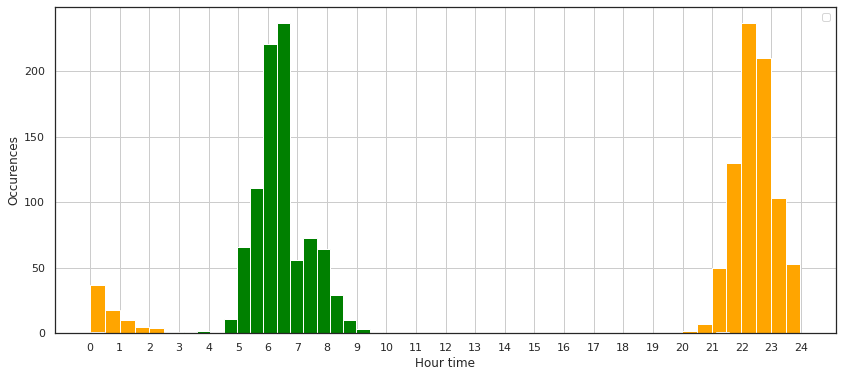

In [81]:
# Histogram showing how many times this person woke up at each hour of the day
plt.figure(figsize=(14,6))

dh = df[df['Start (hours)'] > 3] #To get a proper average because of the outliers between 0 and 3 am.

df['Start (hours)'].hist(color='orange',bins = 48)
df['End (hours)'].hist(color='green',bins =48)
plt.legend() 
plt.xticks(range(0, 25))
plt.xlabel('Hour time')
plt.ylabel('Occurences')

print ('Average starting time :', dh['Start (hours)'].mean(),'hour') #To get a proper average because of the outliers between 0 and 3 am.
print ('Average finishing time :', df['End (hours)'].mean(), 'hour')

In [82]:
dfbefore = df[df['End (hours)'] < 7]
dfafter = df[df['End (hours)'] > 7]

print(dfbefore['Sleep quality'].mean())
print(dfafter['Sleep quality'].mean())
print(dfafter['Sleep quality'].mean() - dfbefore['Sleep quality'].mean())

73.67899408284023
78.7914691943128
5.112475111472563


### 3. Training our data <a class="anchor" id="section_5_2"></a>

Now, we will try to train our data with machine learning to create some models to predict the "Sleep quality" given other features.

For this task, we will use the most relevant features of our data to train the models, so the most correlated ones with the "Sleep quality". Theses are the "Wake up", "Start (hours)", "End (hours)", "Time in bed" (and Activity (steps), which is inversly correlated to "Sleep quality", so can be quite useful).

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


x = data_preprocessed[['Time in bed','Wake up','Start (hours)','End (hours)','Activity (steps)']].values
y = data_preprocessed['Sleep quality'].values

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = 0.25,random_state = 1,
        shuffle=False,
        stratify=None
    )


First we normalize our data before creating any model, it is relevant because all of our data do not share the same range.

In [84]:
scale = MinMaxScaler()
scale.fit(train_x)
test_x = scale.transform(test_x)
train_x = scale.transform(train_x)

Now, we will start with logistic regression : 

In [85]:
clf = LogisticRegression()
clf.fit(train_x, train_y)
print('Accuracy for logistic regression model is :', clf.score(test_x,test_y))

Accuracy for logistic regression model is : 0.04504504504504504


The score is pretty low, so this model is not really useful for predictions.

Then, we do the linear regression : 

In [86]:
clf2 = LinearRegression()
clf2.fit(train_x, train_y)
print('Accuracy for linear regression model is :', clf2.score(test_x,test_y))

Accuracy for linear regression model is : 0.44529570047305356


The score is good, but can still be improved, so we keep trying others models.

For the next model, we will use some clustering, with the KNN (K-nearest neighbors), we will try with different 'K'(neighbors) to see with which one will give us the best accuracy and choose it.

The maximum accuracy for KNN is obtained for 35 neighbors at : 0.04054054054054054


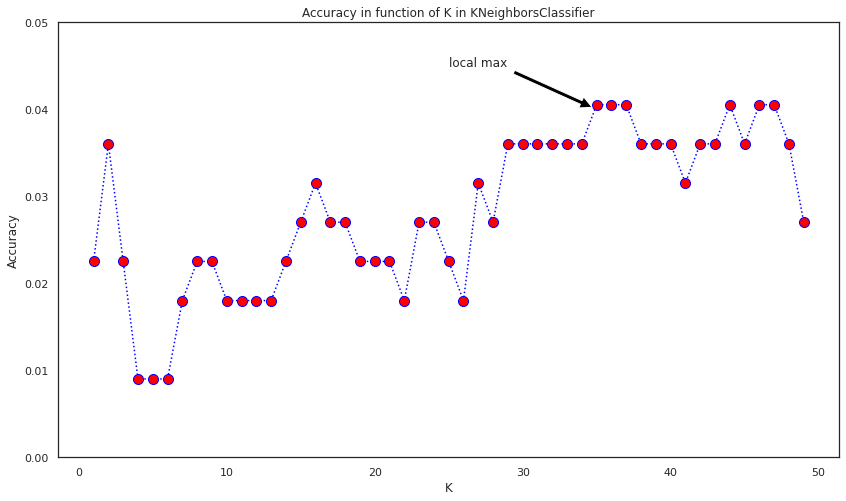

In [87]:
accuracyKNN = []
maxiKNN = 0

for i in range(1,50) : 
    clfKNN = KNeighborsClassifier(n_neighbors=i)
    clfKNN.fit(train_x, train_y)    
    if  maxiKNN < clfKNN.score(test_x,test_y) :
        maxiKNN = clfKNN.score(test_x,test_y)
        uKNN = i
    accuracyKNN.append(clfKNN.score(test_x,test_y))
    

plt.figure(figsize=(14,8))
plt.xlabel('K')
plt.ylim(0,0.05)
plt.ylabel('Accuracy')
plt.title('Accuracy in function of K in KNeighborsClassifier')
fig.tight_layout() 
plt.plot(range(1,50),accuracyKNN, color ='blue',linestyle=':',marker='o',
        markerfacecolor = 'red', markersize=10)

plt.annotate('local max', xy=(35, 0.040), xytext=(25, 0.045),
           arrowprops=dict(facecolor='black', shrink=0.05),)
print("The maximum accuracy for KNN is obtained for",uKNN, "neighbors at :",maxiKNN)

There are others methods using clustering, we will try to use as well KNeighborsRegressor and RadiusNeighborsRegressor in similar ways than KNN, theses might be promising after looking at the results from the logistic regresion model.

Let's try the KNeighborsRegressor model : 

The maximum accuracy for KNR is obtained for 20 neighbors at : 0.39893419173659916


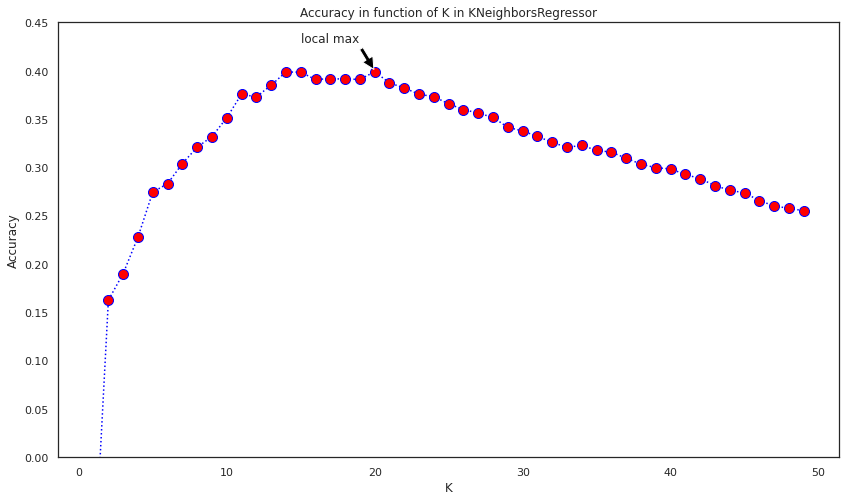

In [88]:
accuracyKNR = []
maxiKNR = 0

for i in range(1,50) : 
    clfKNR = KNeighborsRegressor(n_neighbors=i)
    clfKNR.fit(train_x, train_y)    
    if  maxiKNR < clfKNR.score(test_x,test_y) :
        maxiKNR = clfKNR.score(test_x,test_y)
        uKNR = i
    accuracyKNR.append(clfKNR.score(test_x,test_y))
    
plt.figure(figsize=(14,8))
plt.xlabel('K')
plt.ylim(0,0.45)
plt.ylabel('Accuracy')
plt.title('Accuracy in function of K in KNeighborsRegressor')
fig.tight_layout() 
plt.plot(range(1,50),accuracyKNR, color ='blue',linestyle=':',marker='o',
        markerfacecolor = 'red', markersize=10)

plt.annotate('local max', xy=(20, 0.40), xytext=(15, 0.43),
           arrowprops=dict(facecolor='black', shrink=0.05),)
print("The maximum accuracy for KNR is obtained for",uKNR, "neighbors at :",maxiKNR)

And now the Radius Neighbors Regressor model : 

In [89]:
accuracyRNR = []
maxiRNR = 0

for i in np.linspace(0.0, 1.0, num=40) :
    clfRNR = RadiusNeighborsRegressor(radius=i)
    clfRNR.fit(train_x, train_y)    
    if  maxiRNR < clfRNR.score(test_x,test_y) :
        maxiRNR = clfRNR.score(test_x,test_y)
        uRNR = i
    accuracyRNR.append(clfRNR.score(test_x,test_y))

print("The maximum accuracy for RNR is obtained for radius",uRNR, "at :",maxiRNR)


The maximum accuracy for RNR is obtained for radius 0.2564102564102564 at : 0.4210477280834568


This new model is working really well, the results are good. Sadly, plotting is complicated because of the linspace range. 

Now, we will try to have best results using the Baies Naive Methods :

In [90]:
gauss = GaussianNB()
multi = MultinomialNB()
gauss.fit(train_x,train_y)
ypred = gauss.predict(test_x)
multiNaive = multi.fit(train_x,train_y)
print("The accuracy of Naive Bayes gaussian is",accuracy_score(test_y,ypred), 
      "and for multinomial :",multiNaive.score(test_x,test_y))

The accuracy of Naive Bayes gaussian is 0.0 and for multinomial : 0.03153153153153153


Theses methods are specialized in large datasets, so our is too small to have high quality precision there.

We're using Stochastic Gradient Descent next, which is popular in the neural network world,  it’s used to optimize the cost function :

In [91]:
clfSGDC = SGDClassifier()

clfSGDC.fit(train_x, train_y)

print(" Accuracy for StochasticGradient Descent Classifier :", clfSGDC.score(test_x, test_y), "%")

 Accuracy for StochasticGradient Descent Classifier : 0.02702702702702703 %


This method is specialized in large variety in feature, so it won't perform here sadly.

And for the last one we will use a Random Forest Classifier, which is averaging the predictions from all of the trees, resulting in better performance than any single tree in the model.

In [92]:
clfRDC = RandomForestClassifier()

clfRDC.fit(train_x, train_y)

print(" Accuracy for StochasticGradient Descent Classifier :", clfRDC.score(test_x, test_y), "%")

 Accuracy for StochasticGradient Descent Classifier : 0.04504504504504504 %


We now have some results we can compare, having multiples models and accuracy.

In [93]:
print('Accuracy for logistic regression model is :', clf.score(test_x,test_y))
print('Accuracy for linear regression model is :', clf2.score(test_x,test_y))
print("The maximum accuracy for KNN is obtained for",uKNN, "neighbors at :",maxiKNN)
print("The maximum accuracy for KNR is obtained for",uKNR, "neighbors at :",maxiKNR)
print("The maximum accuracy for RNR is obtained for radius",uRNR, "at :",maxiRNR)
print("The accuracy of Naive Bayes gaussian is",accuracy_score(test_y, ypred), 
      "and for multinomial :",multiNaive.score(test_x,test_y))
print("Accuracy for StochasticGradient Descent Classifier :", clfSGDC.score(test_x, test_y), "%")
print("Accuracy for Random Forest Classifier :", clfRDC.score(test_x, test_y), "%")

Accuracy for logistic regression model is : 0.04504504504504504
Accuracy for linear regression model is : 0.44529570047305356
The maximum accuracy for KNN is obtained for 35 neighbors at : 0.04054054054054054
The maximum accuracy for KNR is obtained for 20 neighbors at : 0.39893419173659916
The maximum accuracy for RNR is obtained for radius 0.2564102564102564 at : 0.4210477280834568
The accuracy of Naive Bayes gaussian is 0.0 and for multinomial : 0.03153153153153153
Accuracy for StochasticGradient Descent Classifier : 0.02702702702702703 %
Accuracy for Random Forest Classifier : 0.04504504504504504 %


So, we can see that the best machine learning models for our data are regression models, namely : the Linear Regression model first, then the Radius Neighbors Regressor model and finally the K Neighbors Regressor model.